In [1]:
# Get all the modules into our path.
import sys
sys.path.insert(0,'/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos')
sys.path.insert(1,'/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github')

# Import machine learning modules.
from omphalos import file_methods as fm
from omphalos import attributes as attr
from omphalos import labels as lbls
import analysis as ana
from analysis import helper as hp

# Import data processing modules.
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
# Import some extra modules
import re
# Import data visualisation modules.
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Port in and unpack all the runs we need from the .pkl file.
train_set = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/cambridge/ai4er/easter/mres/CrunchFlow_Work/bcm/2022-05-27_bcm_4-0/basalt_cl-.pkl')
# Filter any error filled runs
dataset, error = hp.filter_errors(train_set)

Returned 2845 files without errors out of a total possible 5000.
2155 files had errors.
0 files had unhandled errors.
File failure rate: 75.7469244288225 %.
To see unhandled errors, run with verbose=True.


In [3]:
# Scan for errors that are happening
# 0 = successful run
# 1 = timeout
# 2 = condition speciation error
# 3 = charge balance error
# 4 = singular matrix encountered
zeros = 0
ones = 0
twos = 0
threes = 0
fours = 0
for i in error:
    if error[i].error_code == 0:
        zeros += 0
    if error[i].error_code == 1:
        ones += 1
    if error[i].error_code == 2:
        twos += 2
    if error[i].error_code == 3:
        threes += 3
    if error[i].error_code ==4:
        fours += 4
print(f"Successful Runs: {zeros}")
print(f"Timeouts: {ones}")
print(f"Condition Speciation Errors: {twos}")
print(f"Charge Balance Errors: {threes}")
print(f"Singular Matrix Encountered: {fours}")

Successful Runs: 0
Timeouts: 0
Condition Speciation Errors: 0
Charge Balance Errors: 6465
Singular Matrix Encountered: 0


In [4]:
attributes = attr.get_condition(dataset,"basalt",species_concs=True)
attributes = attributes.loc[:, ['Ca++', 'Fe++', 'Mg++', 'HCO3-']]
attributes

/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos/omphalos/attributes.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  species_attrs = species_attrs.append(primary_species(data_set[i], condition), ignore_index=True)


,Ca++,Fe++,Mg++,HCO3-
0,0.000197,0.000010,0.000037,0.82
1,0.000094,0.000251,0.000212,0.82
2,0.000030,0.000245,0.000092,0.82
3,0.000078,0.000016,0.000128,0.82
4,0.000260,0.000135,0.000006,0.82
...,...,...,...,...
2840,0.000263,0.000020,0.000210,0.82
2841,0.000245,0.000107,0.000123,0.82
2842,0.000176,0.000031,0.000255,0.82
2843,0.000272,0.000215,0.000171,0.82


In [5]:
def get_condition_ph(dataset, condition):
    index_vals = []
    ph_vals = []
    for _ in dataset.keys():
        index_vals.append(_)
        ph_vals.append(dataset[_].condition_blocks[condition].contents['pH'])
    ph_df = pd.DataFrame(ph_vals, index=index_vals, columns=['pH'])
    ph_df = ph_df.reset_index(drop=True)
    return ph_df

ph_df = get_condition_ph(dataset, "basalt")

attributes =  pd.concat([attributes, ph_df], axis=1)
attributes

,Ca++,Fe++,Mg++,HCO3-,pH
0,0.000197,0.000010,0.000037,0.82,3.2331365029438874
1,0.000094,0.000251,0.000212,0.82,4.0380821758709935
2,0.000030,0.000245,0.000092,0.82,3.7581693512846828
3,0.000078,0.000016,0.000128,0.82,3.274488392065232
4,0.000260,0.000135,0.000006,0.82,3.750059532357765
...,...,...,...,...,...
2840,0.000263,0.000020,0.000210,0.82,3.5183910175187125
2841,0.000245,0.000107,0.000123,0.82,3.036155925072882
2842,0.000176,0.000031,0.000255,0.82,3.4486894430649
2843,0.000272,0.000215,0.000171,0.82,3.747021276313699


In [6]:
def NrFormatFixer_XYZTime(xr_DataSet):
    for _ in xr_DataSet.X.values:
        for __ in xr_DataSet.Y.values:
            for ___ in xr_DataSet.Z.values:
                for ____ in xr_DataSet.time.values:
                    for _____ in xr_DataSet.data_vars:
                        xr_DataArray = xr_DataSet[f'{_____}'].loc[dict(X=f'{_}',Y=f'{__}',Z=f'{___}',time=f'{____}')]
                        for ______ in range(0,len(xr_DataArray)):
                            string = str(xr_DataArray.values[______])
                            new_val = string
                            if re.match("^\d+\.\d+-\d+$",string):
                                i_rev = 1
                                str_len = len(string)
                                for _______ in reversed(string):
                                    if _______ == "-":
                                        break
                                    else:
                                        i_rev+=1
                                        continue
                                i = str_len - i_rev
                                new_string = string[:i] + "e" + string[i:]
                                new_val = new_string
                            xr_DataArray.values[______] = new_val
    return xr_DataSet

In [7]:
def NrFormatFixer_XYZ(xr_DataSet):
    for _ in xr_DataSet.X.values:
        for __ in xr_DataSet.Y.values:
            for ___ in xr_DataSet.Z.values:
                for _____ in xr_DataSet.data_vars:
                    xr_DataArray = xr_DataSet[f'{_____}'].loc[dict(X=f'{_}',Y=f'{__}',Z=f'{___}')]
                    for ______ in range(0,len(xr_DataArray)):
                        string = str(xr_DataArray.values[______])
                        new_val = string
                        if re.match("^\d+\.\d+-\d+$",string):
                            i_rev = 1
                            str_len = len(string)
                            for _______ in reversed(string):
                                if _______ == "-":
                                    break
                                else:
                                    i_rev+=1
                                    continue
                            i = str_len - i_rev
                            new_string = string[:i] + "e" + string[i:]
                            new_val = new_string
                        xr_DataArray.values[______] = new_val
    return xr_DataSet

In [8]:
final_vols = lbls.raw(dataset, 'volume')
final_vols = NrFormatFixer_XYZTime(final_vols)
final_vols = final_vols.astype(float)

In [9]:
initial_vols = attr.initial_conditions(dataset, concentrations=False, minerals=True)
initial_vols = NrFormatFixer_XYZ(initial_vols)
initial_vols = initial_vols.astype(float)

In [10]:
delt_vf = final_vols - initial_vols
delt_vf

<xarray.Dataset>
Dimensions:       (X: 1, Y: 1, Z: 1, time: 28, file_num: 2845)
Coordinates:
  * X             (X) float64 0.5
  * Y             (Y) float64 0.5
  * Z             (Z) float64 0.5
  * time          (time) float64 0.01 0.02 0.03 0.04 0.05 ... 7.0 8.0 9.0 10.0
Dimensions without coordinates: file_num
Data variables:
    Diopside      (file_num, time, X, Y, Z) float64 -6.463e-06 ... 0.000327
    Hedenbergite  (file_num, time, X, Y, Z) float64 -4.223e-06 ... -0.0003348
    Albite        (file_num, time, X, Y, Z) float64 1.562e-05 ... 1.73e-05
    Anorthite     (file_num, time, X, Y, Z) float64 -2.884e-06 ... -3.734e-06
    M_Microcline  (file_num, time, X, Y, Z) float64 2.2e-07 ... 2.21e-07
    Forsterite    (file_num, time, X, Y, Z) float64 -0.0002771 ... -0.001733
    Fayalite      (file_num, time, X, Y, Z) float64 -0.0001348 ... 5.071e-05
    Calcite       (file_num, time, X, Y, Z) float64 -9.053e-11 ... -1e-10
    Magnesite     (file_num, time, X, Y, Z) float64 1.905e-12 ... 0.001867
    Siderite      (file_num, time, X, Y, Z) float64 0.0001725 ... 8.027e-05

In [11]:
delt_vf_TenYr = delt_vf.sel(X=0.5,Y=0.5,Z=0.5,time=10)
delt_vf_TenYr

<xarray.Dataset>
Dimensions:       (file_num: 2845)
Coordinates:
    X             float64 0.5
    Y             float64 0.5
    Z             float64 0.5
    time          float64 10.0
Dimensions without coordinates: file_num
Data variables:
    Diopside      (file_num) float64 0.000328 0.0003267 ... 0.0003281 0.000327
    Hedenbergite  (file_num) float64 -0.0003351 -0.0003344 ... -0.0003348
    Albite        (file_num) float64 1.73e-05 1.73e-05 ... 1.73e-05 1.73e-05
    Anorthite     (file_num) float64 -3.734e-06 -3.734e-06 ... -3.734e-06
    M_Microcline  (file_num) float64 2.21e-07 2.21e-07 ... 2.21e-07 2.21e-07
    Forsterite    (file_num) float64 -0.001735 -0.001731 ... -0.001734 -0.001733
    Fayalite      (file_num) float64 5.032e-05 5.105e-05 ... 5.074e-05 5.071e-05
    Calcite       (file_num) float64 -1e-10 -1e-10 -1e-10 ... -1e-10 -1e-10
    Magnesite     (file_num) float64 0.001867 0.001867 ... 0.001867 0.001867
    Siderite      (file_num) float64 8.051e-05 7.986e-05 ... 8.035e-05 8.027e-05

In [12]:
delt_vf_TenYr = delt_vf_TenYr.assign(Carbonates=lambda delt_vf_TenYr: delt_vf_TenYr.Calcite + delt_vf_TenYr.Siderite + delt_vf_TenYr.Magnesite)
delt_vf_TenYr

<xarray.Dataset>
Dimensions:       (file_num: 2845)
Coordinates:
    X             float64 0.5
    Y             float64 0.5
    Z             float64 0.5
    time          float64 10.0
Dimensions without coordinates: file_num
Data variables:
    Diopside      (file_num) float64 0.000328 0.0003267 ... 0.0003281 0.000327
    Hedenbergite  (file_num) float64 -0.0003351 -0.0003344 ... -0.0003348
    Albite        (file_num) float64 1.73e-05 1.73e-05 ... 1.73e-05 1.73e-05
    Anorthite     (file_num) float64 -3.734e-06 -3.734e-06 ... -3.734e-06
    M_Microcline  (file_num) float64 2.21e-07 2.21e-07 ... 2.21e-07 2.21e-07
    Forsterite    (file_num) float64 -0.001735 -0.001731 ... -0.001734 -0.001733
    Fayalite      (file_num) float64 5.032e-05 5.105e-05 ... 5.074e-05 5.071e-05
    Calcite       (file_num) float64 -1e-10 -1e-10 -1e-10 ... -1e-10 -1e-10
    Magnesite     (file_num) float64 0.001867 0.001867 ... 0.001867 0.001867
    Siderite      (file_num) float64 8.051e-05 7.986e-05 ... 8.035e-05 8.027e-05
    Carbonates    (file_num) float64 0.001947 0.001947 ... 0.001947 0.001947

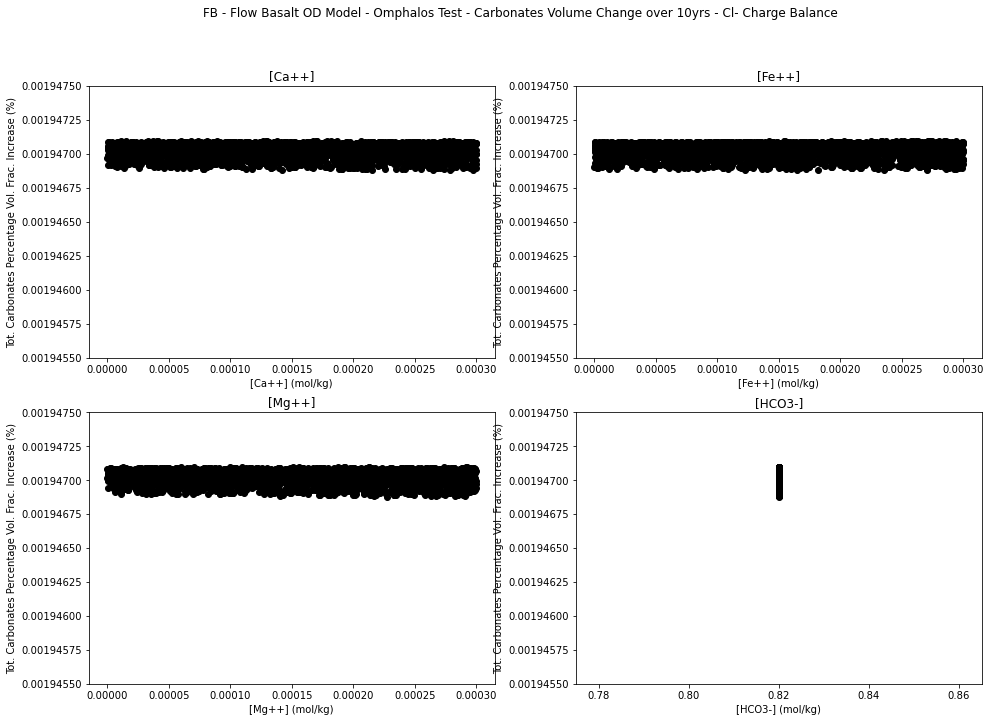

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.suptitle('FB - Flow Basalt OD Model - Omphalos Test - Carbonates Volume Change over 10yrs - Cl- Charge Balance')

fig.set_figheight(11)
fig.set_figwidth(16)

ax1.set_title("[Ca++]")
ax2.set_title("[Fe++]")
ax3.set_title("[Mg++]")
ax4.set_title("[HCO3-]")
ax1.set_ylabel('Tot. Carbonates Percentage Vol. Frac. Increase (%)')
ax2.set_ylabel('Tot. Carbonates Percentage Vol. Frac. Increase (%)')
ax3.set_ylabel('Tot. Carbonates Percentage Vol. Frac. Increase (%)')
ax4.set_ylabel('Tot. Carbonates Percentage Vol. Frac. Increase (%)')
ax1.set_xlabel('[Ca++] (mol/kg)')
ax2.set_xlabel('[Fe++] (mol/kg)')
ax3.set_xlabel('[Mg++] (mol/kg)')
ax4.set_xlabel('[HCO3-] (mol/kg)')
ax1.set_ylim(bottom=0.0019455, top=0.0019475)
ax2.set_ylim(bottom=0.0019455, top=0.0019475)
ax3.set_ylim(bottom=0.0019455, top=0.0019475)
ax4.set_ylim(bottom=0.0019455, top=0.0019475)

for x_value,run_number,y_value in zip(attributes["Ca++"].values, delt_vf_TenYr.Carbonates.file_num.values, delt_vf_TenYr.Carbonates.values):
    ax1.plot(x_value, y_value, color='black', marker='o')
for x_value,run_number,y_value in zip(attributes["Fe++"].values, delt_vf_TenYr.Carbonates.file_num.values, delt_vf_TenYr.Carbonates.values):
    ax2.plot(x_value, y_value, color='black', marker='o')
for x_value,run_number,y_value in zip(attributes["Mg++"].values, delt_vf_TenYr.Carbonates.file_num.values, delt_vf_TenYr.Carbonates.values):
    ax3.plot(x_value, y_value, color='black', marker='o')
for x_value,run_number,y_value in zip(attributes["HCO3-"].values, delt_vf_TenYr.Carbonates.file_num.values, delt_vf_TenYr.Carbonates.values):
    ax4.plot(x_value, y_value, color='black', marker='o')

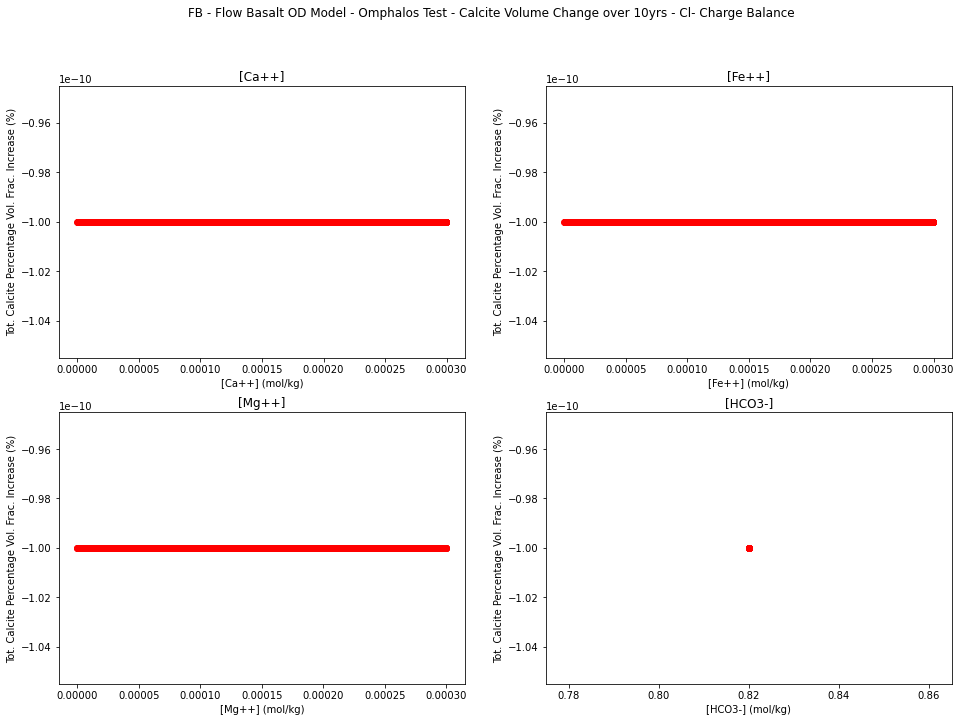

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.suptitle('FB - Flow Basalt OD Model - Omphalos Test - Calcite Volume Change over 10yrs - Cl- Charge Balance')

fig.set_figheight(11)
fig.set_figwidth(16)

ax1.set_title("[Ca++]")
ax2.set_title("[Fe++]")
ax3.set_title("[Mg++]")
ax4.set_title("[HCO3-]")
ax1.set_ylabel('Tot. Calcite Percentage Vol. Frac. Increase (%)')
ax2.set_ylabel('Tot. Calcite Percentage Vol. Frac. Increase (%)')
ax3.set_ylabel('Tot. Calcite Percentage Vol. Frac. Increase (%)')
ax4.set_ylabel('Tot. Calcite Percentage Vol. Frac. Increase (%)')
ax1.set_xlabel('[Ca++] (mol/kg)')
ax2.set_xlabel('[Fe++] (mol/kg)')
ax3.set_xlabel('[Mg++] (mol/kg)')
ax4.set_xlabel('[HCO3-] (mol/kg)')
# ax1.set_ylim(bottom=0.0019455, top=0.0019475)
# ax2.set_ylim(bottom=0.0019455, top=0.0019475)
# ax3.set_ylim(bottom=0.0019455, top=0.0019475)
# ax4.set_ylim(bottom=0.0019455, top=0.0019475)

for x_value,run_number,y_value in zip(attributes["Ca++"].values, delt_vf_TenYr.Calcite.file_num.values, delt_vf_TenYr.Calcite.values):
    ax1.plot(x_value, y_value, color='red', marker='o')
for x_value,run_number,y_value in zip(attributes["Fe++"].values, delt_vf_TenYr.Calcite.file_num.values, delt_vf_TenYr.Calcite.values):
    ax2.plot(x_value, y_value, color='red', marker='o')
for x_value,run_number,y_value in zip(attributes["Mg++"].values, delt_vf_TenYr.Calcite.file_num.values, delt_vf_TenYr.Calcite.values):
    ax3.plot(x_value, y_value, color='red', marker='o')
for x_value,run_number,y_value in zip(attributes["HCO3-"].values, delt_vf_TenYr.Calcite.file_num.values, delt_vf_TenYr.Calcite.values):
    ax4.plot(x_value, y_value, color='red', marker='o')

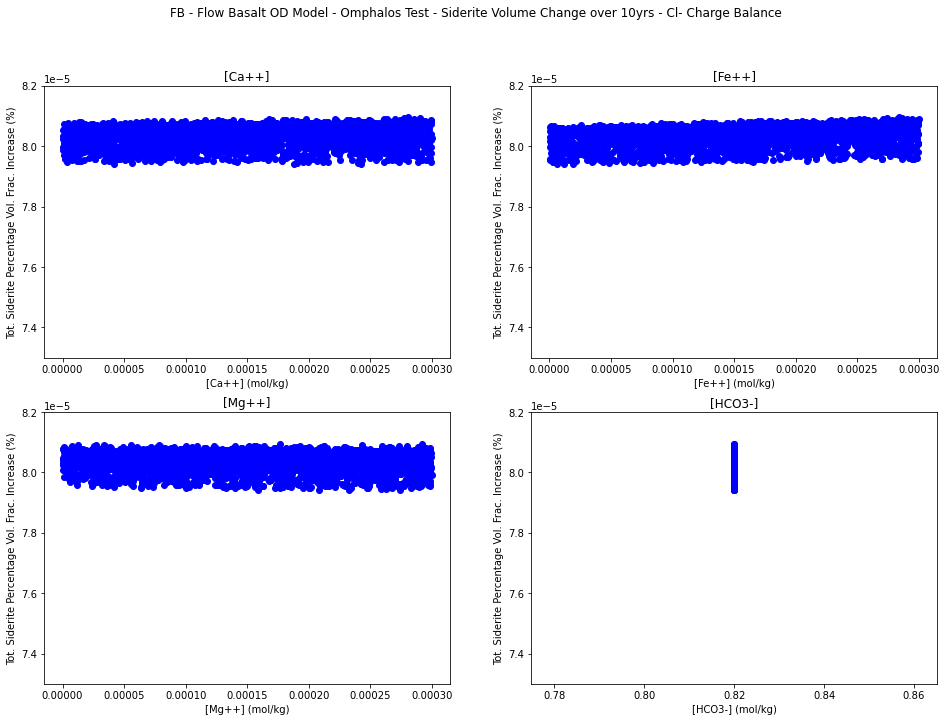

In [15]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.suptitle('FB - Flow Basalt OD Model - Omphalos Test - Siderite Volume Change over 10yrs - Cl- Charge Balance')

fig.set_figheight(11)
fig.set_figwidth(16)

ax1.set_title("[Ca++]")
ax2.set_title("[Fe++]")
ax3.set_title("[Mg++]")
ax4.set_title("[HCO3-]")
ax1.set_ylabel('Tot. Siderite Percentage Vol. Frac. Increase (%)')
ax2.set_ylabel('Tot. Siderite Percentage Vol. Frac. Increase (%)')
ax3.set_ylabel('Tot. Siderite Percentage Vol. Frac. Increase (%)')
ax4.set_ylabel('Tot. Siderite Percentage Vol. Frac. Increase (%)')
ax1.set_xlabel('[Ca++] (mol/kg)')
ax2.set_xlabel('[Fe++] (mol/kg)')
ax3.set_xlabel('[Mg++] (mol/kg)')
ax4.set_xlabel('[HCO3-] (mol/kg)')
ax1.set_ylim(bottom=7.3e-5, top=8.2e-5)
ax2.set_ylim(bottom=7.3e-5, top=8.2e-5)
ax3.set_ylim(bottom=7.3e-5, top=8.2e-5)
ax4.set_ylim(bottom=7.3e-5, top=8.2e-5)

for x_value,run_number,y_value in zip(attributes["Ca++"].values, delt_vf_TenYr.Siderite.file_num.values, delt_vf_TenYr.Siderite.values):
    ax1.plot(x_value, y_value, color='blue', marker='o')
for x_value,run_number,y_value in zip(attributes["Fe++"].values, delt_vf_TenYr.Siderite.file_num.values, delt_vf_TenYr.Siderite.values):
    ax2.plot(x_value, y_value, color='blue', marker='o')
for x_value,run_number,y_value in zip(attributes["Mg++"].values, delt_vf_TenYr.Siderite.file_num.values, delt_vf_TenYr.Siderite.values):
    ax3.plot(x_value, y_value, color='blue', marker='o')
for x_value,run_number,y_value in zip(attributes["HCO3-"].values, delt_vf_TenYr.Siderite.file_num.values, delt_vf_TenYr.Siderite.values):
    ax4.plot(x_value, y_value, color='blue', marker='o')

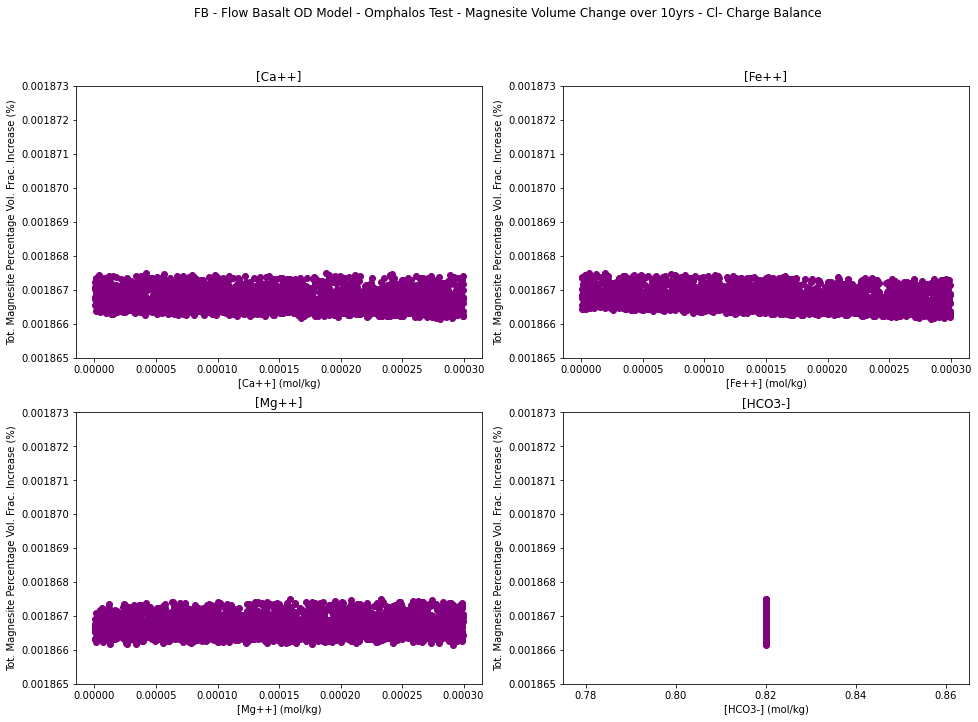

In [16]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.suptitle('FB - Flow Basalt OD Model - Omphalos Test - Magnesite Volume Change over 10yrs - Cl- Charge Balance')

fig.set_figheight(11)
fig.set_figwidth(16)

ax1.set_title("[Ca++]")
ax2.set_title("[Fe++]")
ax3.set_title("[Mg++]")
ax4.set_title("[HCO3-]")
ax1.set_ylabel('Tot. Magnesite Percentage Vol. Frac. Increase (%)')
ax2.set_ylabel('Tot. Magnesite Percentage Vol. Frac. Increase (%)')
ax3.set_ylabel('Tot. Magnesite Percentage Vol. Frac. Increase (%)')
ax4.set_ylabel('Tot. Magnesite Percentage Vol. Frac. Increase (%)')
ax1.set_xlabel('[Ca++] (mol/kg)')
ax2.set_xlabel('[Fe++] (mol/kg)')
ax3.set_xlabel('[Mg++] (mol/kg)')
ax4.set_xlabel('[HCO3-] (mol/kg)')
ax1.set_ylim(bottom=0.001865, top=0.001873)
ax2.set_ylim(bottom=0.001865, top=0.001873)
ax3.set_ylim(bottom=0.001865, top=0.001873)
ax4.set_ylim(bottom=0.001865, top=0.001873)

for x_value,run_number,y_value in zip(attributes["Ca++"].values, delt_vf_TenYr.Magnesite.file_num.values, delt_vf_TenYr.Magnesite.values):
    ax1.plot(x_value, y_value, color='purple', marker='o')
for x_value,run_number,y_value in zip(attributes["Fe++"].values, delt_vf_TenYr.Magnesite.file_num.values, delt_vf_TenYr.Magnesite.values):
    ax2.plot(x_value, y_value, color='purple', marker='o')
for x_value,run_number,y_value in zip(attributes["Mg++"].values, delt_vf_TenYr.Magnesite.file_num.values, delt_vf_TenYr.Magnesite.values):
    ax3.plot(x_value, y_value, color='purple', marker='o')
for x_value,run_number,y_value in zip(attributes["HCO3-"].values, delt_vf_TenYr.Magnesite.file_num.values, delt_vf_TenYr.Magnesite.values):
    ax4.plot(x_value, y_value, color='purple', marker='o')

[3.2331365  4.03808218 3.75816935 ... 3.44868944 3.74702128 3.69644598]


AttributeError: 'numpy.ndarray' object has no attribute 'get_array'

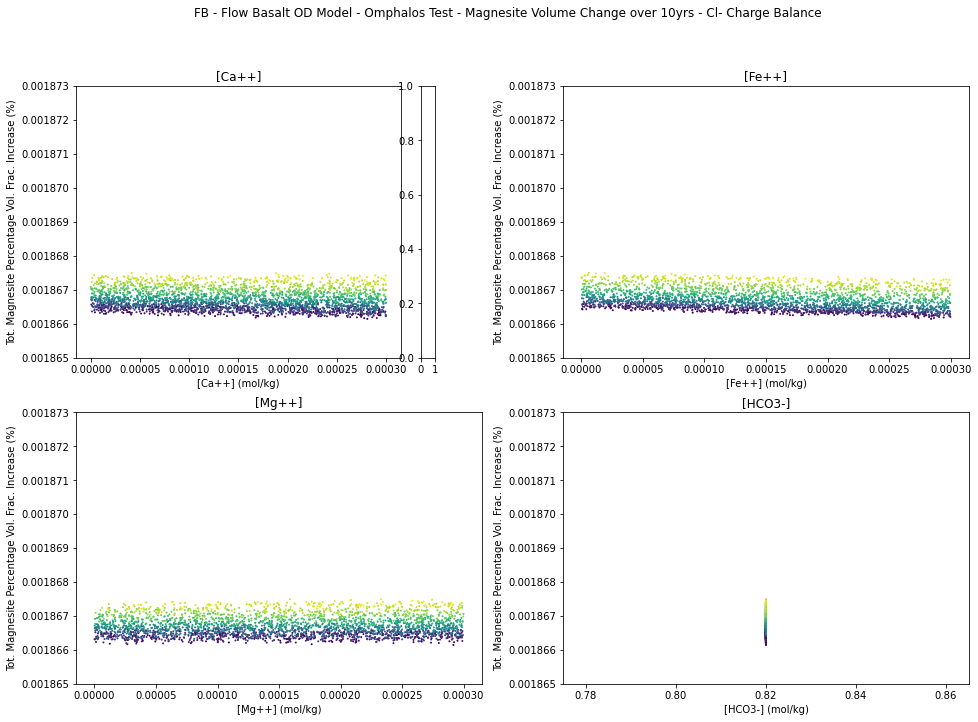

In [21]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.suptitle('FB - Flow Basalt OD Model - Omphalos Test - Magnesite Volume Change over 10yrs - Cl- Charge Balance')

fig.set_figheight(11)
fig.set_figwidth(16)

ax1.set_title("[Ca++]")
ax2.set_title("[Fe++]")
ax3.set_title("[Mg++]")
ax4.set_title("[HCO3-]")
ax1.set_ylabel('Tot. Magnesite Percentage Vol. Frac. Increase (%)')
ax2.set_ylabel('Tot. Magnesite Percentage Vol. Frac. Increase (%)')
ax3.set_ylabel('Tot. Magnesite Percentage Vol. Frac. Increase (%)')
ax4.set_ylabel('Tot. Magnesite Percentage Vol. Frac. Increase (%)')
ax1.set_xlabel('[Ca++] (mol/kg)')
ax2.set_xlabel('[Fe++] (mol/kg)')
ax3.set_xlabel('[Mg++] (mol/kg)')
ax4.set_xlabel('[HCO3-] (mol/kg)')
ax1.set_ylim(bottom=0.001865, top=0.001873)
ax2.set_ylim(bottom=0.001865, top=0.001873)
ax3.set_ylim(bottom=0.001865, top=0.001873)
ax4.set_ylim(bottom=0.001865, top=0.001873)

ax1_x = attributes["Ca++"].values
ax1_y = delt_vf_TenYr.Magnesite.values
ax1_c = attributes['pH'].values.astype(float)
ax2_x = attributes["Fe++"].values
ax2_y = delt_vf_TenYr.Magnesite.values
ax2_c = attributes['pH'].values.astype(float)
ax3_x = attributes["Mg++"].values
ax3_y = delt_vf_TenYr.Magnesite.values
ax3_c = attributes['pH'].values.astype(float)
ax4_x = attributes["HCO3-"].values
ax4_y = delt_vf_TenYr.Magnesite.values
ax4_c = attributes['pH'].values.astype(float)

ax1.scatter(x=ax1_x, y=ax1_y, s=1, c=ax1_c, cmap='viridis')
ax2.scatter(x=ax2_x, y=ax2_y, s=1, c=ax2_c, cmap='viridis')
ax3.scatter(x=ax3_x, y=ax3_y, s=1, c=ax3_c, cmap='viridis')
ax4.scatter(x=ax4_x, y=ax4_y, s=1, c=ax4_c, cmap='viridis')